Mounted at /content/drive

===== Training Data =====
Shape: (8693, 14)

Missing values:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Data types:
PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

First few rows:
  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa  

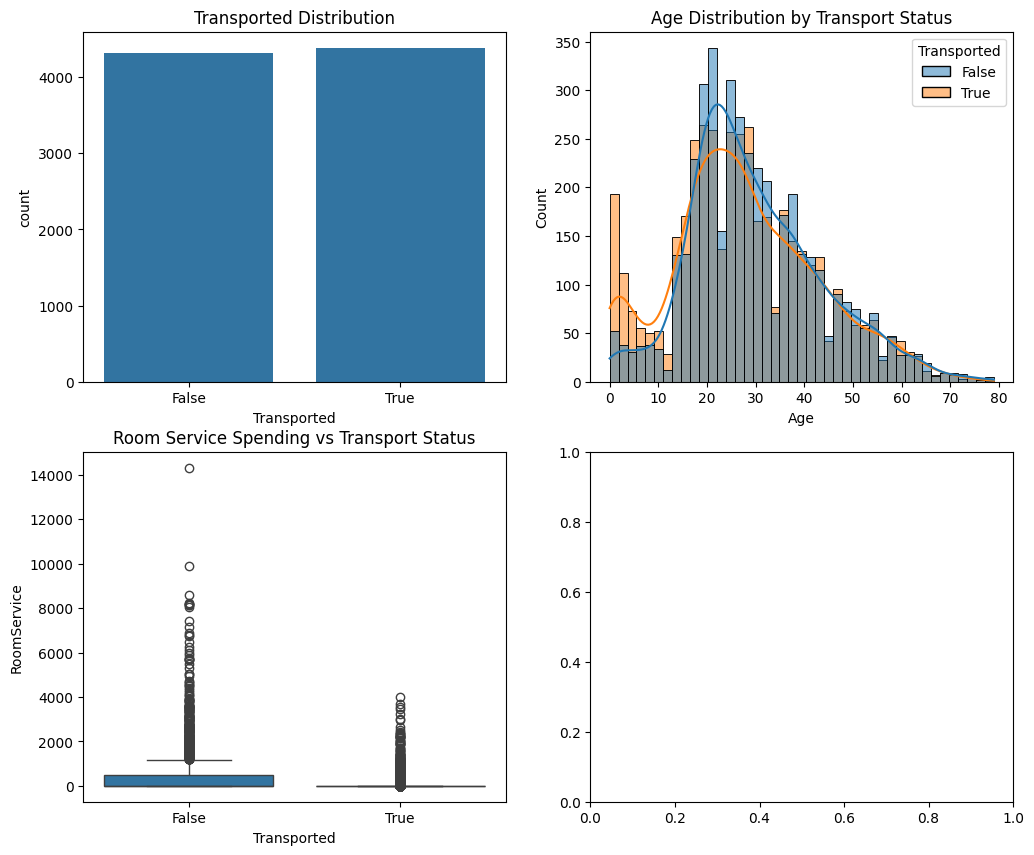

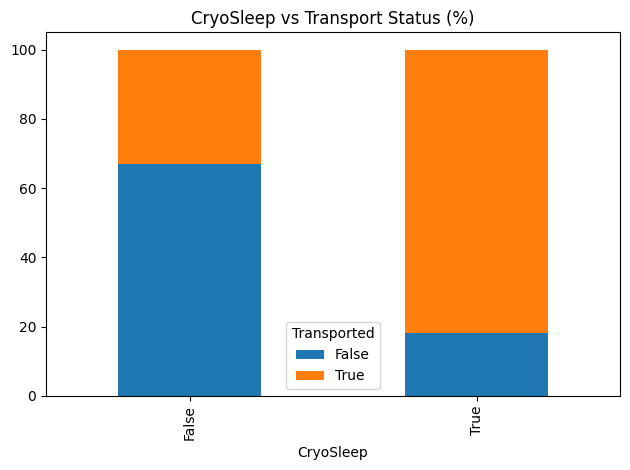

KeyError: 'Friends'

In [1]:
# Spaceship Titanic Challenge Solution

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from google.colab import drive
drive.mount('/content/drive')

# 1. Load the data
train_data = pd.read_csv('/content/drive/MyDrive/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/test.csv')

# Keep a copy of the PassengerId for the final submission
test_passenger_ids = test_data['PassengerId']

# 2. Exploratory Data Analysis
def explore_data(df, title):
    print(f"\n===== {title} =====")
    print(f"Shape: {df.shape}")
    print("\nMissing values:")
    print(df.isnull().sum())
    print("\nData types:")
    print(df.dtypes)
    print("\nFirst few rows:")
    print(df.head())

    if 'Transported' in df.columns:
        print("\nTarget variable distribution:")
        print(df['Transported'].value_counts(normalize=True) * 100)

# Run EDA on both datasets
explore_data(train_data, "Training Data")
explore_data(test_data, "Test Data")

# Visualize some key relationships
if 'Transported' in train_data.columns:
    plt.figure(figsize=(12, 10))

    # 1. Target distribution
    plt.subplot(2, 2, 1)
    sns.countplot(x='Transported', data=train_data)
    plt.title('Transported Distribution')

    # 2. Age distribution by transport status
    plt.subplot(2, 2, 2)
    sns.histplot(data=train_data, x='Age', hue='Transported', kde=True)
    plt.title('Age Distribution by Transport Status')

    # 3. Spending and transport status
    plt.subplot(2, 2, 3)
    sns.boxplot(x='Transported', y='RoomService', data=train_data)
    plt.title('Room Service Spending vs Transport Status')

    # 4. CryoSleep and transport status
    plt.subplot(2, 2, 4)
    cryo_transported = pd.crosstab(train_data['CryoSleep'], train_data['Transported'], normalize='index') * 100
    cryo_transported.plot(kind='bar', stacked=True)
    plt.title('CryoSleep vs Transport Status (%)')

    plt.tight_layout()
    plt.show()

# 3. Feature Engineering

# Combine datasets for preprocessing
train_len = len(train_data)
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Extract cabin information
combined_data[['Deck', 'Cabin_num', 'Side']] = combined_data['Cabin'].str.split('/', expand=True)

# Extract passenger group info from PassengerId
combined_data['Group'] = combined_data['PassengerId'].str.split('_', expand=True)[0]
combined_data['IsGroup'] = combined_data.groupby('Group')['Group'].transform('count') > 1

# Create a total spent feature
spending_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
combined_data['TotalSpent'] = combined_data[spending_columns].sum(axis=1)
combined_data['HasSpent'] = combined_data['TotalSpent'] > 0

# Create feature for traveling alone (neither friends nor family)
combined_data['TravelingAlone'] = (combined_data['Friends'] + combined_data['Family']) == 0

# Display the engineered features
print("\n===== Feature Engineering =====")
print(combined_data[['Deck', 'Cabin_num', 'Side', 'Group', 'IsGroup', 'TotalSpent', 'HasSpent', 'TravelingAlone']].head())

# 4. Data Preprocessing for Modeling

# Split back into train and test
train_processed = combined_data[:train_len]
test_processed = combined_data[train_len:]

# Define feature columns
numeric_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSpent']
categorical_features = ['HomePlanet', 'Destination', 'Deck', 'Side', 'CryoSleep', 'VIP', 'IsGroup', 'TravelingAlone']
boolean_features = ['HasSpent']

# Define preprocessors
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

boolean_transformer = SimpleImputer(strategy='most_frequent')

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('bool', boolean_transformer, boolean_features)
    ])

# 5. Model Training and Evaluation

# Prepare train data
X = train_processed.drop(['PassengerId', 'Name', 'Cabin', 'Transported', 'Group', 'Cabin_num'], axis=1)
y = train_processed['Transported'].astype(int)

# Split for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models to try
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

# Create a model selection function
def evaluate_models(models_dict, X_train, y_train, X_val, y_val):
    results = {}

    for name, model in models_dict.items():
        print(f"\nTraining {name}...")

        # Create full pipeline with preprocessing
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        # Train
        pipeline.fit(X_train, y_train)

        # Predict
        y_pred = pipeline.predict(X_val)

        # Evaluate
        accuracy = accuracy_score(y_val, y_pred)
        results[name] = {
            'accuracy': accuracy,
            'pipeline': pipeline
        }

        print(f"{name} Accuracy: {accuracy:.4f}")
        print(classification_report(y_val, y_pred))

        # Plot confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Not Transported', 'Transported'],
                   yticklabels=['Not Transported', 'Transported'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix - {name}')
        plt.show()

    return results

# Run model evaluation
model_results = evaluate_models(models, X_train, y_train, X_val, y_val)

# 6. Hyperparameter Tuning for the best model
# Let's say XGBoost performed best
best_model_name = max(model_results, key=lambda k: model_results[k]['accuracy'])
print(f"\nPerforming hyperparameter tuning for {best_model_name}...")

# Example hyperparameter grid for XGBoost
if best_model_name == 'XGBoost':
    param_grid = {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.01, 0.1]
    }
elif best_model_name == 'Random Forest':
    param_grid = {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5]
    }
else:  # Gradient Boosting
    param_grid = {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 5],
        'model__learning_rate': [0.01, 0.1]
    }

# Create pipeline for tuning
tuning_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', models[best_model_name])
])

# Perform grid search
grid_search = GridSearchCV(
    tuning_pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Print best parameters
print("\nBest parameters:")
print(grid_search.best_params_)
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Evaluate the tuned model
y_pred_tuned = grid_search.predict(X_val)
tuned_accuracy = accuracy_score(y_val, y_pred_tuned)
print(f"\nTuned model validation accuracy: {tuned_accuracy:.4f}")
print(classification_report(y_val, y_pred_tuned))

# 7. Make predictions on the test set
X_test = test_processed.drop(['PassengerId', 'Name', 'Cabin', 'Group', 'Cabin_num'], axis=1)
if 'Transported' in X_test.columns:
    X_test = X_test.drop('Transported', axis=1)

# Use the best tuned model
final_predictions = grid_search.predict(X_test)

# 8. Create submission file
submission = pd.DataFrame({
    'PassengerId': test_passenger_ids,
    'Transported': final_predictions.astype(bool)
})

submission.to_csv('submission.csv', index=False)
print("\nSubmission file created!")

# Show a sample of the predictions
print("\nSample predictions:")
print(submission.head(10))


===== Training Data =====
Shape: (8693, 14)

Missing values:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Data types:
PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

First few rows:
  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-

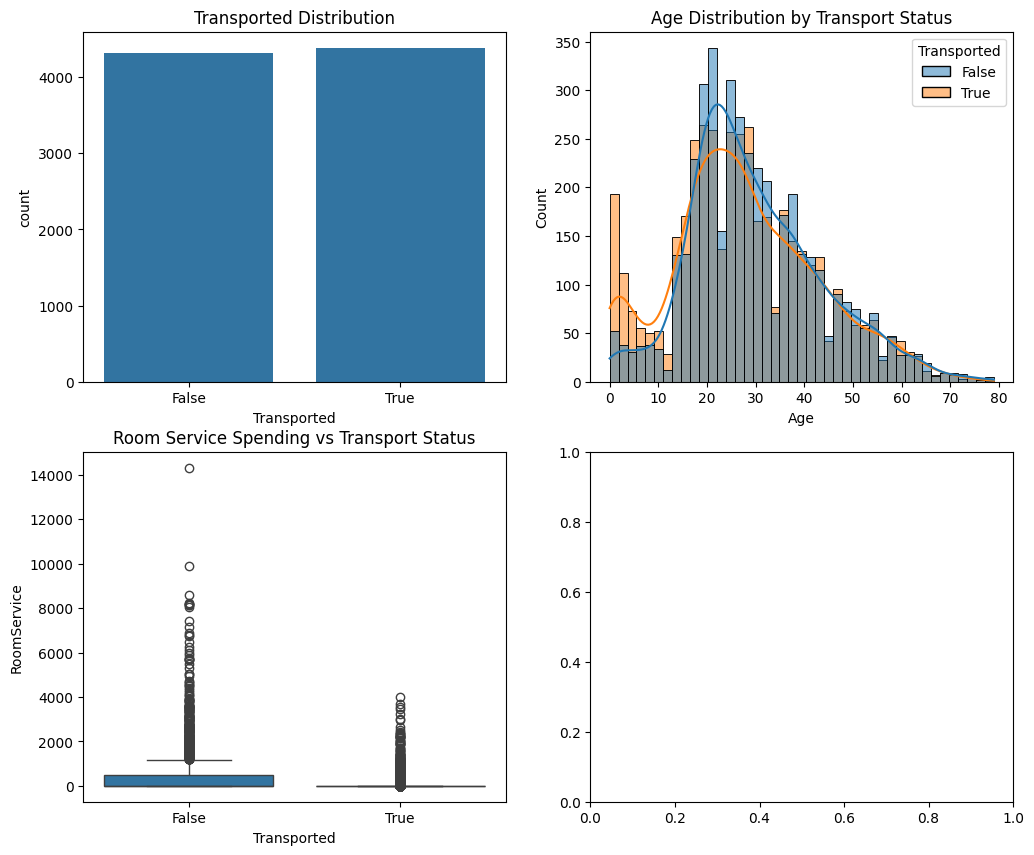

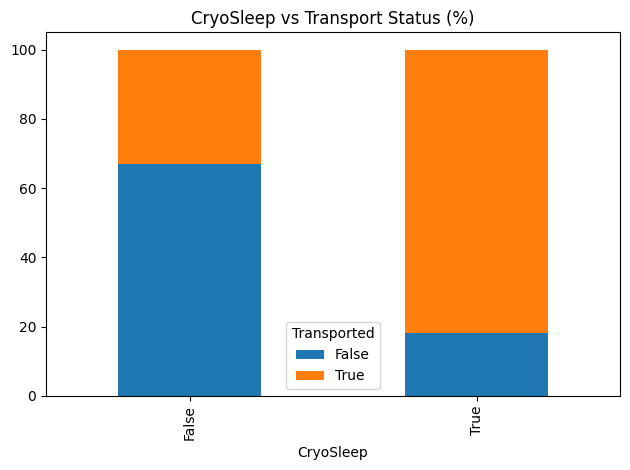


===== Feature Engineering =====
  Deck Cabin_num Side Group  IsGroup  TotalSpent  HasSpent
0    B         0    P  0001    False         0.0     False
1    F         0    S  0002    False       736.0      True
2    A         0    S  0003     True     10383.0      True
3    A         0    S  0003     True      5176.0      True
4    F         1    S  0004    False      1091.0      True

Training Random Forest...


ValueError: SimpleImputer does not support data with dtype bool. Please provide either a numeric array (with a floating point or integer dtype) or categorical data represented either as an array with integer dtype or an array of string values with an object dtype.

In [4]:
# Spaceship Titanic Challenge Solution

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Load the data
train_data = pd.read_csv('/content/drive/MyDrive/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/test.csv')


# Keep a copy of the PassengerId for the final submission
test_passenger_ids = test_data['PassengerId']

# 2. Exploratory Data Analysis
def explore_data(df, title):
    print(f"\n===== {title} =====")
    print(f"Shape: {df.shape}")
    print("\nMissing values:")
    print(df.isnull().sum())
    print("\nData types:")
    print(df.dtypes)
    print("\nFirst few rows:")
    print(df.head())

    if 'Transported' in df.columns:
        print("\nTarget variable distribution:")
        print(df['Transported'].value_counts(normalize=True) * 100)

# Run EDA on both datasets
explore_data(train_data, "Training Data")
explore_data(test_data, "Test Data")

# Visualize some key relationships
if 'Transported' in train_data.columns:
    plt.figure(figsize=(12, 10))

    # 1. Target distribution
    plt.subplot(2, 2, 1)
    sns.countplot(x='Transported', data=train_data)
    plt.title('Transported Distribution')

    # 2. Age distribution by transport status
    plt.subplot(2, 2, 2)
    sns.histplot(data=train_data, x='Age', hue='Transported', kde=True)
    plt.title('Age Distribution by Transport Status')

    # 3. Spending and transport status
    plt.subplot(2, 2, 3)
    sns.boxplot(x='Transported', y='RoomService', data=train_data)
    plt.title('Room Service Spending vs Transport Status')

    # 4. CryoSleep and transport status
    plt.subplot(2, 2, 4)
    cryo_transported = pd.crosstab(train_data['CryoSleep'], train_data['Transported'], normalize='index') * 100
    cryo_transported.plot(kind='bar', stacked=True)
    plt.title('CryoSleep vs Transport Status (%)')

    plt.tight_layout()
    plt.show()

# 3. Feature Engineering

# Combine datasets for preprocessing
train_len = len(train_data)
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Extract cabin information
combined_data[['Deck', 'Cabin_num', 'Side']] = combined_data['Cabin'].str.split('/', expand=True)

# Extract passenger group info from PassengerId
combined_data['Group'] = combined_data['PassengerId'].str.split('_', expand=True)[0]
combined_data['IsGroup'] = combined_data.groupby('Group')['Group'].transform('count') > 1

# Create a total spent feature
spending_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
combined_data['TotalSpent'] = combined_data[spending_columns].sum(axis=1)
combined_data['HasSpent'] = combined_data['TotalSpent'] > 0

# Display the engineered features
print("\n===== Feature Engineering =====")
print(combined_data[['Deck', 'Cabin_num', 'Side', 'Group', 'IsGroup', 'TotalSpent', 'HasSpent']].head())

# 4. Data Preprocessing for Modeling

# Split back into train and test
train_processed = combined_data[:train_len]
test_processed = combined_data[train_len:]

# Define feature columns
numeric_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSpent']
categorical_features = ['HomePlanet', 'Destination', 'Deck', 'Side', 'CryoSleep', 'VIP', 'IsGroup']
boolean_features = ['HasSpent']

# Define preprocessors
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Change the boolean_transformer to handle boolean data type
boolean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value=False)), # Handle boolean
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary')) # Convert to numerical
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('bool', boolean_transformer, boolean_features)
    ])

# 5. Model Training and Evaluation

# Prepare train data
X = train_processed.drop(['PassengerId', 'Name', 'Cabin', 'Transported', 'Group', 'Cabin_num'], axis=1)
y = train_processed['Transported'].astype(int)

# Split for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models to try
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier.XGBClassifier(random_state=42)
}

# Create a model selection function
def evaluate_models(models_dict, X_train, y_train, X_val, y_val):
    results = {}

    for name, model in models_dict.items():
        print(f"\nTraining {name}...")

        # Create full pipeline with preprocessing
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        # Train
        pipeline.fit(X_train, y_train)

        # Predict
        y_pred = pipeline.predict(X_val)

        # Evaluate
        accuracy = accuracy_score(y_val, y_pred)
        results[name] = {
            'accuracy': accuracy,
            'pipeline': pipeline
        }

        print(f"{name} Accuracy: {accuracy:.4f}")
        print(classification_report(y_val, y_pred))

        # Plot confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Not Transported', 'Transported'],
                   yticklabels=['Not Transported', 'Transported'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix - {name}')
        plt.show()

    return results

# Run model evaluation
model_results = evaluate_models(models, X_train, y_train, X_val, y_val)

# 6. Hyperparameter Tuning for the best model
# Let's say XGBoost performed best
best_model_name = max(model_results, key=lambda k: model_results[k]['accuracy'])
print(f"\nPerforming hyperparameter tuning for {best_model_name}...")

# Example hyperparameter grid for XGBoost
if best_model_name == 'XGBoost':
    param_grid = {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.01, 0.1]
    }
elif best_model_name == 'Random Forest':
    param_grid = {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5]
    }
else:  # Gradient Boosting
    param_grid = {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 5],
        'model__learning_rate': [0.01, 0.1]
    }

# Create pipeline for tuning
tuning_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', models[best_model_name])
])

# Perform grid search
grid_search = GridSearchCV(
    tuning_pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Print best parameters
print("\nBest parameters:")
print(grid_search.best_params_)
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Evaluate the tuned model
y_pred_tuned = grid_search.predict(X_val)
tuned_accuracy = accuracy_score(y_val, y_pred_tuned)
print(f"\nTuned model validation accuracy: {tuned_accuracy:.4f}")
print(classification_report(y_val, y_pred_tuned))

# 7. Make predictions on the test set
X_test = test_processed.drop(['PassengerId', 'Name', 'Cabin', 'Group', 'Cabin_num'], axis=1)
if 'Transported' in X_test.columns:
    X_test = X_test.drop('Transported', axis=1)

# Use the best tuned model
final_predictions = grid_search.predict(X_test)

# 8. Create submission file
submission = pd.DataFrame({
    'PassengerId': test_passenger_ids,
    'Transported': final_predictions.astype(bool)
})

submission.to_csv('submission.csv', index=False)
print("\nSubmission file created!")

# Show a sample of the predictions
print("\nSample predictions:")
print(submission.head(10))


===== Training Data =====
Shape: (8693, 14)

Missing values:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Data types:
PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

First few rows:
  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-

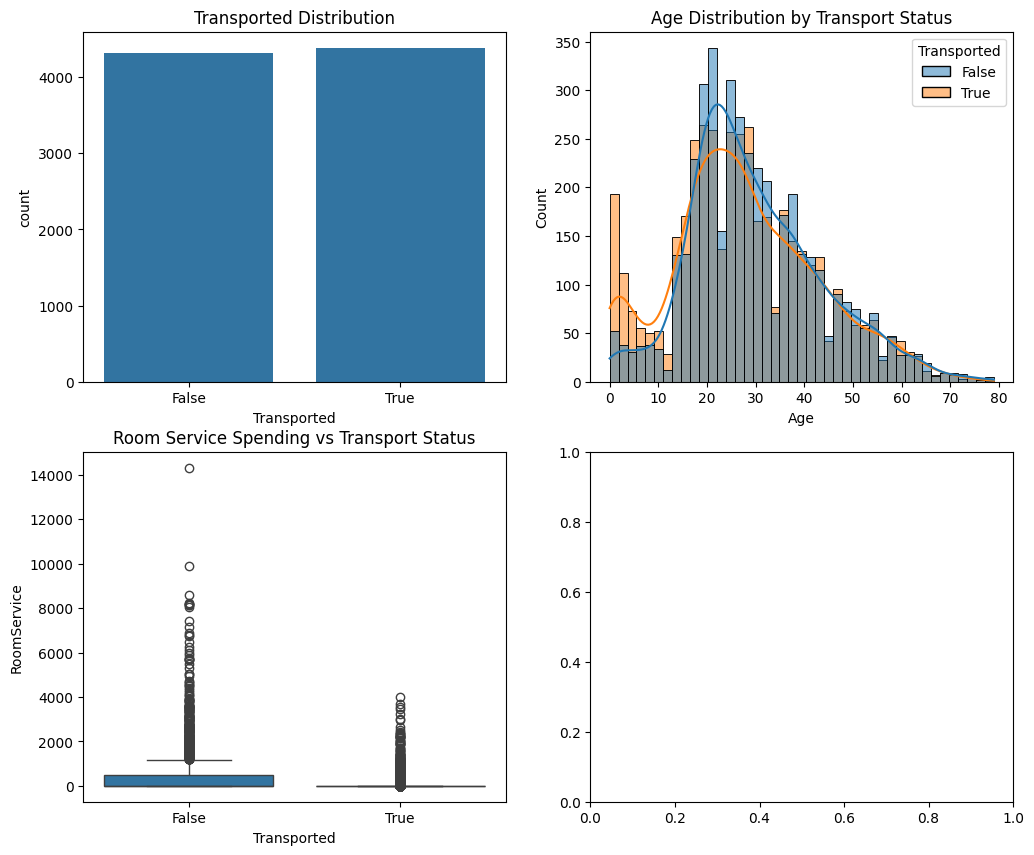

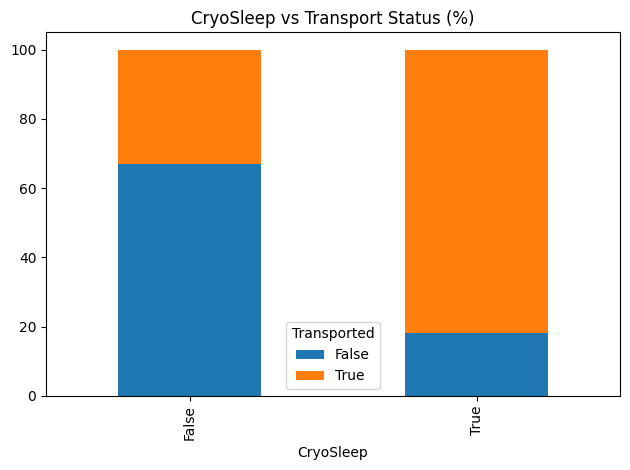


===== Feature Engineering =====
  Deck Cabin_num Side Group  IsGroup  TotalSpent  HasSpent
0    B         0    P  0001        0         0.0         0
1    F         0    S  0002        0       736.0         1
2    A         0    S  0003        1     10383.0         1
3    A         0    S  0003        1      5176.0         1
4    F         1    S  0004        0      1091.0         1

Training Random Forest...
Random Forest Accuracy: 0.7826
              precision    recall  f1-score   support

           0       0.76      0.81      0.79       861
           1       0.80      0.75      0.78       878

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739



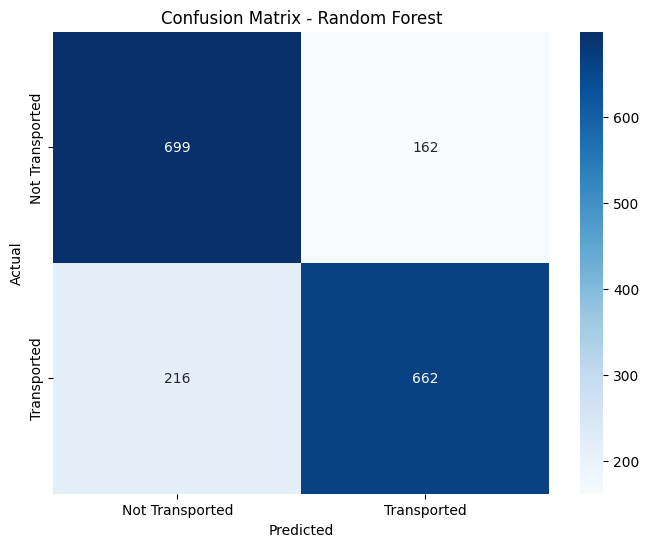


Training Gradient Boosting...
Gradient Boosting Accuracy: 0.7878
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       861
           1       0.77      0.84      0.80       878

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



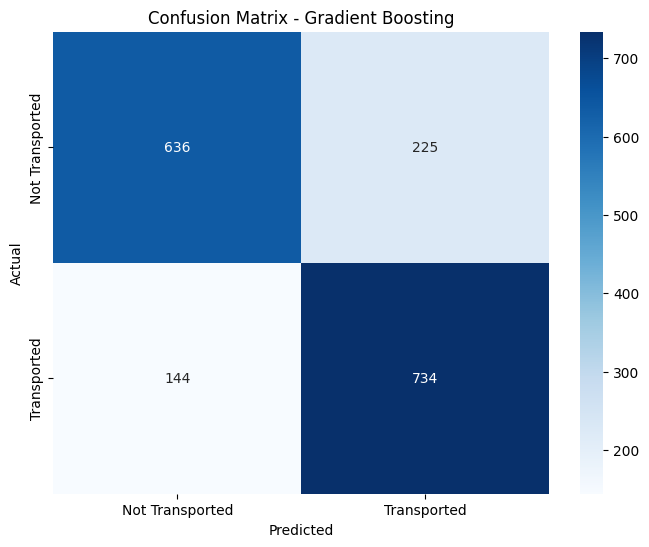


Training XGBoost...
XGBoost Accuracy: 0.7936
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       861
           1       0.79      0.81      0.80       878

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



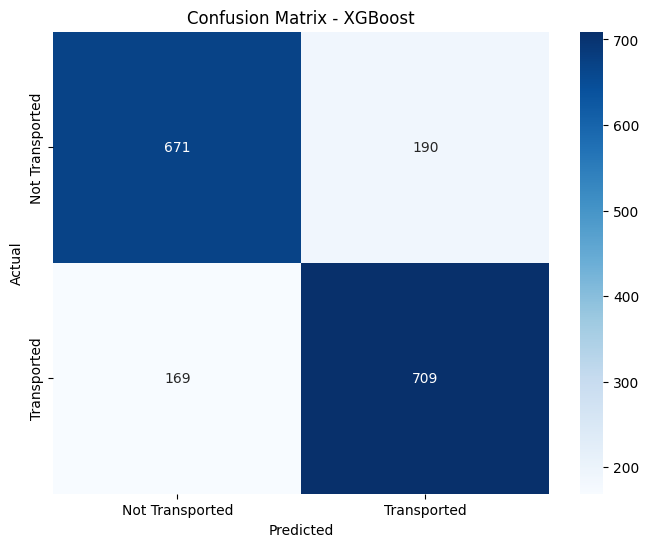


Performing hyperparameter tuning for XGBoost...

Best parameters:
{'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 100}
Best cross-validation accuracy: 0.8108

Tuned model validation accuracy: 0.7964
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       861
           1       0.79      0.82      0.80       878

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739


Submission file created!

Sample predictions:
  PassengerId  Transported
0     0013_01         True
1     0018_01        False
2     0019_01         True
3     0021_01         True
4     0023_01         True
5     0027_01         True
6     0029_01         True
7     0032_01         True
8     0032_02         True
9     0033_01         True


In [5]:
# Spaceship Titanic Challenge Solution

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Load the data
train_data = pd.read_csv('/content/drive/MyDrive/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/test.csv')

# Keep a copy of the PassengerId for the final submission
test_passenger_ids = test_data['PassengerId']

# 2. Exploratory Data Analysis
def explore_data(df, title):
    print(f"\n===== {title} =====")
    print(f"Shape: {df.shape}")
    print("\nMissing values:")
    print(df.isnull().sum())
    print("\nData types:")
    print(df.dtypes)
    print("\nFirst few rows:")
    print(df.head())

    if 'Transported' in df.columns:
        print("\nTarget variable distribution:")
        print(df['Transported'].value_counts(normalize=True) * 100)

# Run EDA on both datasets
explore_data(train_data, "Training Data")
explore_data(test_data, "Test Data")

# Visualize some key relationships
if 'Transported' in train_data.columns:
    plt.figure(figsize=(12, 10))

    # 1. Target distribution
    plt.subplot(2, 2, 1)
    sns.countplot(x='Transported', data=train_data)
    plt.title('Transported Distribution')

    # 2. Age distribution by transport status
    plt.subplot(2, 2, 2)
    sns.histplot(data=train_data, x='Age', hue='Transported', kde=True)
    plt.title('Age Distribution by Transport Status')

    # 3. Spending and transport status
    plt.subplot(2, 2, 3)
    sns.boxplot(x='Transported', y='RoomService', data=train_data)
    plt.title('Room Service Spending vs Transport Status')

    # 4. CryoSleep and transport status
    plt.subplot(2, 2, 4)
    cryo_transported = pd.crosstab(train_data['CryoSleep'], train_data['Transported'], normalize='index') * 100
    cryo_transported.plot(kind='bar', stacked=True)
    plt.title('CryoSleep vs Transport Status (%)')

    plt.tight_layout()
    plt.show()

# 3. Feature Engineering

# Combine datasets for preprocessing
train_len = len(train_data)
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Extract cabin information
combined_data[['Deck', 'Cabin_num', 'Side']] = combined_data['Cabin'].str.split('/', expand=True)

# Extract passenger group info from PassengerId
combined_data['Group'] = combined_data['PassengerId'].str.split('_', expand=True)[0]
combined_data['IsGroup'] = combined_data.groupby('Group')['Group'].transform('count') > 1
# Convert boolean to integer (0, 1) to avoid issues with SimpleImputer
combined_data['IsGroup'] = combined_data['IsGroup'].astype(int)

# Create a total spent feature
spending_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
combined_data['TotalSpent'] = combined_data[spending_columns].sum(axis=1)
combined_data['HasSpent'] = (combined_data['TotalSpent'] > 0).astype(int)  # Convert to int instead of bool

# Display the engineered features
print("\n===== Feature Engineering =====")
print(combined_data[['Deck', 'Cabin_num', 'Side', 'Group', 'IsGroup', 'TotalSpent', 'HasSpent']].head())

# 4. Data Preprocessing for Modeling

# Split back into train and test
train_processed = combined_data[:train_len]
test_processed = combined_data[train_len:]

# Define feature columns - add HasSpent and IsGroup to numeric features instead of boolean
numeric_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSpent', 'HasSpent', 'IsGroup']
categorical_features = ['HomePlanet', 'Destination', 'Deck', 'Side', 'CryoSleep', 'VIP']

# Define preprocessors
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 5. Model Training and Evaluation

# Prepare train data
X = train_processed.drop(['PassengerId', 'Name', 'Cabin', 'Transported', 'Group', 'Cabin_num'], axis=1)
y = train_processed['Transported'].astype(int)

# Split for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models to try
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier.XGBClassifier(random_state=42)
}

# Create a model selection function
def evaluate_models(models_dict, X_train, y_train, X_val, y_val):
    results = {}

    for name, model in models_dict.items():
        print(f"\nTraining {name}...")

        # Create full pipeline with preprocessing
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        # Train
        pipeline.fit(X_train, y_train)

        # Predict
        y_pred = pipeline.predict(X_val)

        # Evaluate
        accuracy = accuracy_score(y_val, y_pred)
        results[name] = {
            'accuracy': accuracy,
            'pipeline': pipeline
        }

        print(f"{name} Accuracy: {accuracy:.4f}")
        print(classification_report(y_val, y_pred))

        # Plot confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Not Transported', 'Transported'],
                   yticklabels=['Not Transported', 'Transported'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix - {name}')
        plt.show()

    return results

# Run model evaluation
model_results = evaluate_models(models, X_train, y_train, X_val, y_val)

# 6. Hyperparameter Tuning for the best model
# Let's say XGBoost performed best
best_model_name = max(model_results, key=lambda k: model_results[k]['accuracy'])
print(f"\nPerforming hyperparameter tuning for {best_model_name}...")

# Example hyperparameter grid for XGBoost
if best_model_name == 'XGBoost':
    param_grid = {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.01, 0.1]
    }
elif best_model_name == 'Random Forest':
    param_grid = {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5]
    }
else:  # Gradient Boosting
    param_grid = {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 5],
        'model__learning_rate': [0.01, 0.1]
    }

# Create pipeline for tuning
tuning_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', models[best_model_name])
])

# Perform grid search
grid_search = GridSearchCV(
    tuning_pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Print best parameters
print("\nBest parameters:")
print(grid_search.best_params_)
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Evaluate the tuned model
y_pred_tuned = grid_search.predict(X_val)
tuned_accuracy = accuracy_score(y_val, y_pred_tuned)
print(f"\nTuned model validation accuracy: {tuned_accuracy:.4f}")
print(classification_report(y_val, y_pred_tuned))

# 7. Make predictions on the test set
X_test = test_processed.drop(['PassengerId', 'Name', 'Cabin', 'Group', 'Cabin_num'], axis=1)
if 'Transported' in X_test.columns:
    X_test = X_test.drop('Transported', axis=1)

# Use the best tuned model
final_predictions = grid_search.predict(X_test)

# 8. Create submission file
submission = pd.DataFrame({
    'PassengerId': test_passenger_ids,
    'Transported': final_predictions.astype(bool)
})

submission.to_csv('submission.csv', index=False)
print("\nSubmission file created!")

# Show a sample of the predictions
print("\nSample predictions:")
print(submission.head(10))